In [1]:
import pandas as pd
import pickle
from engarde.decorators import has_dtypes
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from capstone_project import preprocessor

In [2]:
# Make sure that the loaded dataframe has the correct layout otherwise throw assertion error 
@has_dtypes(dict(question1=object, question2=object, is_duplicate=int))
def load_and_check_data(filename):
    """Load dataframe using filename as input. A pandas dataframe is returned and it is checked that it 
    has the layout that is defined by the decorators.
    """
    df = pd.read_pickle(filename)
    return df

In [23]:
# The current working directory for python is the capstone_project/notebook folder
file_directory = "../output/data/"

X = load_and_check_data(file_directory+"train_data.pkl")
X = X[0:10]

In [ ]:
X.fillna("", inplace=True)  # Two questions have empty fields
words = unicode(question, "utf8")
words = preprocessor.tokenize(words)

In [24]:
model = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin.gz', binary=True)

test = X["question1"].apply(question2vec)

[[ -1.43554688e-01   2.16796875e-01   3.88183594e-02   8.98437500e-02
   -3.03649902e-03  -1.25976562e-01   8.69140625e-02  -9.37500000e-02
   -3.49121094e-02   1.62109375e-01  -1.38671875e-01   1.90429688e-01
   -8.10546875e-02   1.31835938e-01  -5.46875000e-02  -2.66113281e-02
   -1.88476562e-01   1.49414062e-01  -7.37304688e-02   1.63085938e-01
   -1.69921875e-01   1.78710938e-01   1.15722656e-01   2.92968750e-02
    1.17187500e-01  -7.47070312e-02   9.57031250e-02   1.38671875e-01
   -7.42187500e-02  -2.55859375e-01   1.09375000e-01   1.81640625e-01
   -2.98828125e-01  -2.00195312e-01   5.41992188e-02  -6.88476562e-02
    7.42187500e-02   8.15429688e-02   7.61718750e-02   1.77734375e-01
    7.86132812e-02   3.54003906e-02   1.79687500e-01   1.21093750e-01
   -1.97753906e-02  -2.40234375e-01  -1.42578125e-01   5.34057617e-03
   -1.14257812e-01   3.02734375e-01   1.91406250e-01   1.76757812e-01
   -9.86328125e-02  -1.86523438e-01  -5.00488281e-03  -3.29589844e-02
   -2.16796875e-01  

KeyError: u"word 'nra' not in vocabulary"

In [20]:
print test.iloc[0]

[  1.82878338e-02   9.04482082e-02   2.39183251e-02  -5.76562295e-03
  -1.05149420e-02  -1.51347592e-02   1.40762273e-02  -8.47726688e-02
   1.92337576e-02   3.88166048e-02   2.66660042e-02   6.56740442e-02
   1.27023878e-02   8.95473287e-02  -6.51673004e-02   3.41883413e-02
   1.12609817e-02   1.17114209e-01  -3.64630595e-02   1.69365164e-02
   2.96389051e-02   2.68011377e-03  -6.35119379e-02   1.10988237e-01
   6.99081719e-02   3.23528014e-02   8.24303832e-03   3.31523307e-02
   8.37817043e-02   1.30627388e-02   2.56299954e-02  -1.29276076e-02
  -6.37822002e-02  -6.00886010e-02   7.01784417e-02  -2.10129917e-02
   2.22517010e-02   5.16203418e-02   1.66662540e-02   3.15757915e-02
   4.96158861e-02  -1.90535821e-02   3.83323841e-02   6.57641366e-02
   1.94139332e-02  -1.43059507e-01  -4.52691466e-02  -1.34512428e-02
  -6.56740442e-02   1.71707451e-01   3.50690298e-02   1.44320741e-01
  -2.24318765e-02  -3.65756676e-02  -9.66192223e-03   3.36027704e-02
  -7.73854703e-02  -9.27904919e-02

In [4]:
tfidf = preprocessor.TfidfTransformer()
feature_engineering = preprocessor.FeatureTransformer()

y = X["is_duplicate"].values

feature_creator = FeatureUnion([('feature_engineering', feature_engineering), ('tfidf', tfidf)])
clf = LogisticRegression()


#pipe = Pipeline([("features", feature_creator), ("logistic", clf)])
pipe = Pipeline([("features", feature_engineering), ("logistic", clf)])

print pipe.get_params().keys()

['logistic__max_iter', 'logistic__verbose', 'features', 'logistic__solver', 'logistic__tol', 'logistic__penalty', 'logistic__dual', 'logistic__fit_intercept', 'logistic__warm_start', 'steps', 'logistic__multi_class', 'logistic', 'logistic__class_weight', 'logistic__C', 'logistic__random_state', 'logistic__intercept_scaling', 'logistic__n_jobs']


In [5]:
#http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [6]:
from scipy.stats import uniform
from time import time

skf = StratifiedKFold(n_splits=3, random_state=12574, shuffle=True)

#print cross_val_score(pipe, X, y, scoring="neg_log_loss", cv=skf)
#print cross_val_score(pipe, X, y, scoring="accuracy", cv=skf)

param_dist = {"logistic__C": uniform(0, 5)}
n_iter_search = 20
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=n_iter_search, cv=skf, scoring="neg_log_loss")
random_search.fit(X, y)
              
start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)  

#for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #y_train, y_test = y[train_index], y[test_index]

RandomizedSearchCV took 4.05 seconds for 20 candidates parameter settings.


NameError: global name 'np' is not defined

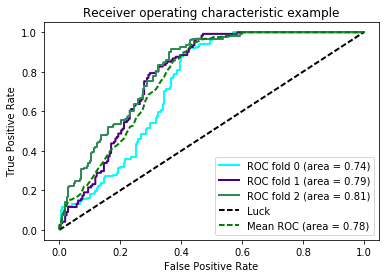

In [6]:
def save_output(dataset, filename):
    with open (filename, "wb") as handle:
        pickle.dump(dataset, handle)

In [23]:
output_directory = "../output/models/"
prefix = "first_test_"

save_output(skf, output_directory+prefix+"kfolds.pkl") 
save_output(pipe, output_directory+prefix+"logistic_pipeline.pkl") 

1
2
3
